In [1]:
!pip install pesto-pitch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 2.9 MB/s eta 0:00:00


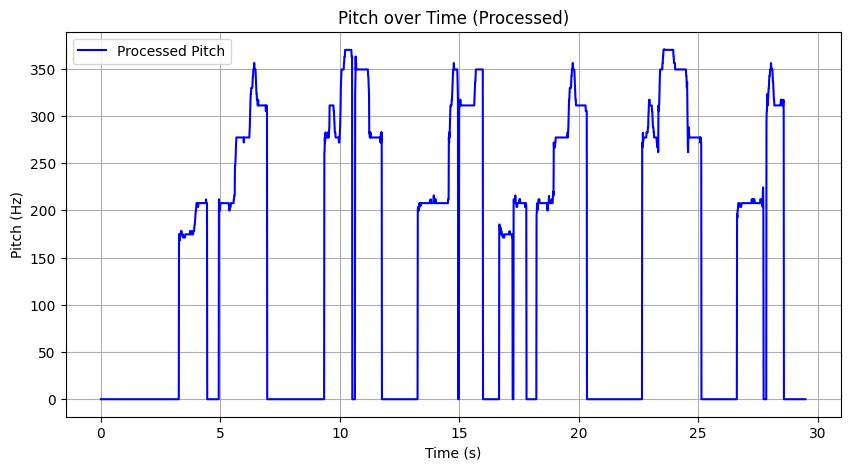

MIDI 파일이 생성되었습니다.


In [8]:
import torchaudio
import pesto
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

# 피치 예측
timesteps, pitch, confidence, activations = pesto.predict(x, sr)

# 오디오 파일의 총 길이 (초)
audio_length = x.shape[-1] / sr

# timesteps를 numpy 배열로 변환하고, 원본 오디오 길이에 맞게 스케일링
scaled_timesteps = timesteps.numpy() * (audio_length / timesteps[-1].item())

# 무음 구간 임계값 설정 (예: confidence 값이 0.5 이하일 때 무음으로 간주)
silence_threshold = 0.7

# 공백 처리된 피치 배열 생성
processed_pitch = np.array([
    pitch[i] if confidence[i] >= silence_threshold else 0  # 무음 구간은 피치를 0으로 설정
    for i in range(len(pitch))
])

# 피치 그래프 그리기 (공백 처리 후)
plt.figure(figsize=(10, 5))
plt.plot(scaled_timesteps, processed_pitch, label="Processed Pitch", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Pitch (Hz)")
plt.title("Pitch over Time (Processed)")
plt.legend()
plt.grid(True)
plt.show()

# 피치를 MIDI 노트로 변환하는 함수
def pitch_to_midi(pitch):
    if pitch > 0:  # 피치가 0보다 큰 유효한 값만 변환
        midi_note = int(np.round(69 + 12 * np.log2(pitch / 440.0)))
        return midi_note if 0 <= midi_note <= 127 else None  # 유효한 MIDI 노트 범위
    return None

# pretty_midi 객체 생성
midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)  # 기본 프로그램 (0: Acoustic Grand Piano)

# 각 피치를 MIDI로 변환하여 추가
for i in range(len(scaled_timesteps) - 1):
    if confidence[i] < silence_threshold:  # 무음 구간인 경우 피치를 0으로 처리
        continue  # 무음으로 간주하고 MIDI에 추가하지 않음

    midi_note = pitch_to_midi(pitch[i])
    if midi_note is not None:  # 유효한 피치만 추가
        start_time = float(scaled_timesteps[i])  # 노트 시작 시간
        end_time = float(scaled_timesteps[i + 1])  # 노트 종료 시간
        note = pretty_midi.Note(
            velocity=100,  # 노트 속도 (세기)
            pitch=midi_note,  # 변환된 MIDI 피치
            start=start_time,  # 노트 시작 시간
            end=end_time  # 노트 종료 시간
        )
        instrument.notes.append(note)

# 트랙에 악기 추가
midi.instruments.append(instrument)

# MIDI 파일로 저장
midi.write('outputi.mid')
print("MIDI 파일이 생성되었습니다.")
